# Self-Driving Car Engineer Nanodegree


## Project: **Behavior Cloning** 
***
In this project we will be workin on creating a deep neural network and train it to drive the car autonomously in the simulator.

---


## Import Packages

In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split


correction = 0.1
#correction array for center, left and right images accessed in the loop below
cr_ar = np.array([0,correction,-correction])

epochs = 4

Using TensorFlow backend.


In [2]:
#Load data
print('load samples')
samples = []
#forward loop - driving counter clockwise
with open('./data1/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
#reverse loop - clockwise run
with open('./data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

#data from bridge        
with open('./data3/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

#data from corners
with open('./data4/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


load samples


## Read in an Image

In [ ]:


print('reading images')
images = []
measurements = []
for line in samples:
    for i in range(3):
        source_path = line[i] # 0 - center img, 1- left img and 2- right img
        #having multiple folders for different data sets # folder path + img + file path
        current_path = './'+line[i].split('/')[-3]+'/IMG/'+line[i].split('/')[-1]
        image = cv2.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append((measurement+cr_ar[i]))
        images.append(np.fliplr(image))
        measurements.append(-(measurement+cr_ar[i]))

X_train = np.array(images)
y_train = np.array(measurements)


#Augment the data

# Keras NN
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

#Lenet Model
model.add(Convolution2D(6,5,5,activation = 'relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(16,5,5,activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
#end lenet model
model.compile(loss = 'mse',optimizer = 'adam')
print('Training')
history_object = model.fit(X_train,y_train,validation_split = 0.2,shuffle=True,nb_epoch = epochs,verbose=1)
#"""
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
#"""


## Code with Generator

Epoch 1/4
57312/57312 [==============================] - 116s - loss: 0.1169 - val_loss: 0.0499
Epoch 2/4
57312/57312 [==============================] - 116s - loss: 0.0497 - val_loss: 0.0501
Epoch 3/4
57312/57312 [==============================] - 116s - loss: 0.0467 - val_loss: 0.0531
Epoch 4/4
57312/57312 [==============================] - 117s - loss: 0.0447 - val_loss: 0.0563
dict_keys(['val_loss', 'loss'])


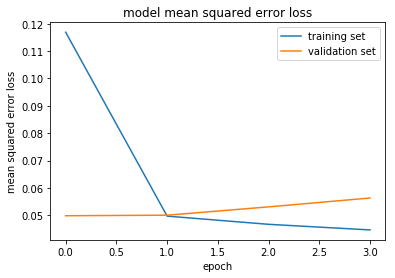

In [4]:

(train_samples, validation_samples) = train_test_split(samples,test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)

    # Loop forever so the generator never terminates

    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):

            batch_samples = samples[offset:offset + batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):  # i = 0 - center img, 1- left img and 2- right img

                    # having multiple folders for different data sets # folder path + img + file path

                    current_path = './' + batch_sample[i].split('/'
                            )[-3] + '/IMG/' + batch_sample[i].split('/'
                            )[-1]
                    image = cv2.imread(current_path)
                    angle = float(batch_sample[3])
                    images.append(image)
                    angles.append(angle + cr_ar[i])
                    images.append(np.fliplr(image))
                    angles.append(-(angle + cr_ar[i]))

            # trim image to only see section with road

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model = Sequential()
model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(160, 320, 3),
          output_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))

model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(16, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples) * 6,
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    nb_epoch=epochs,
    verbose=1,
    )

### print the keys contained in the history object

print(history_object.history.keys())

### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_g_1.h5')



## Ideas for Lane Detection Pipeline

Now for the one with the solid yellow lane on the left. This one's more tricky!